In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np

In [72]:
# read in csv & display first 5 rows
kdramaData = pd.read_csv("kdramas_dataset.csv")
kdramaData.head()

,Rank,Title,Year of release,Number of Episodes,Rating,Description,Genre,Tags,Actors
0,#1,Move to Heaven,2021,10,9.2,Geu Roo is a young autistic man. He works for ...,"Life, Drama, Family","Autism, Uncle-Nephew Relationship, Death, Sava...","Lee Je Hoon, Tang Jun Sang, Hong Seung Hee, Ju..."
1,#2,Twinkling Watermelon,2023,16,9.2,"In 2023, high school student Eun Gyeol, a CODA...","Romance, Youth, Drama, Fantasy","Time Travel, Child From The Future, Sign Langu...","Ha Eun-Gyeol, Ha Yi-Chan, Choi Se-Kyung, Yoon ..."
2,#3,Moving,2023,20,9.1,"Kim Bong Seok, Jang Hui Su, and Lee Gang Hun, ...","Action, Thriller, Mystery, Supernatural","Graphic Violence, Supernatural Power, Multiple...","Ryu Seung Ryong, Han Hyo Joo, Zo In Sung"
3,#4,The Trauma Code: Heroes on Call,2025,8,9.1,"Baek Gang Hyeok, a genius trauma surgeon with ...","Action, Comedy, Drama, Medical","Surgeon Male Lead, Hospital Setting, Mentor-Me...","Ju Ji Hoon, Choo Young Woo, Ha Young, Yoon Gyu..."
4,#5,Flower of Evil,2020,16,9.1,Although Baek Hee Sung is hiding a dark secret...,"Thriller, Romance, Crime, Melodrama","Married Couple, Deception, Suspense, Family Se...","Lee Joon Gi, Moon Chae Won, Jang Hee Jin, Seo ..."


In [74]:
# display data info
kdramaData.info()
# seems to have no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                350 non-null    object 
 1   Title               350 non-null    object 
 2   Year of release     350 non-null    int64  
 3   Number of Episodes  350 non-null    int64  
 4   Rating              350 non-null    float64
 5   Description         350 non-null    object 
 6   Genre               350 non-null    object 
 7   Tags                350 non-null    object 
 8   Actors              350 non-null    object 
dtypes: float64(1), int64(2), object(6)
memory usage: 24.7+ KB


In [76]:
# General Statistical Overview
# rounded to the nearest tenth
kdramaData.describe().drop(index='count').round(1)

,Year of release,Number of Episodes,Rating
mean,2019.8,18.3,8.4
std,3.7,14.6,0.5
min,2003.0,1.0,6.4
25%,2018.0,12.0,8.3
50%,2020.0,16.0,8.4
75%,2023.0,16.0,8.6
max,2025.0,133.0,9.2


In [78]:
# Preprocessing
kdramaData['Genre'] = kdramaData['Genre'].apply(lambda x: x.split(', '))

kdramaData['Actor Set'] = kdramaData['Actors'].apply(lambda x: ' '.join(x.split(', ')) if isinstance(x, str) and x.strip() != '' else 'Unknown')

mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(kdramaData['Genre'])

genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

In [80]:
X = kdramaData[['Number of Episodes', 'Actor Set']]
y = kdramaData['Rating']  # target label: Rating

# TfidfVectorizer
tfidf = TfidfVectorizer(max_features=500)
X_actors = tfidf.fit_transform(X['Actor Set'])

X_combined = np.hstack([genre_df.values, X_actors.toarray(), X[['Number of Episodes']].values])

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [82]:
# create and train model
model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# display example predictions
correct_preds = np.where(np.isclose(y_pred, y_test, atol=0.1))[0]  # Using a tolerance (atol) to allow small error

for idx in correct_preds[:5]:
    print(f"\nMovie Title: {kdramaData.iloc[idx]['Title']}")
    print(f"True Rating: {y_test.iloc[idx]}")
    print(f"Predicted Rating: {y_pred[idx]}")
    print(f"Genres: {kdramaData.iloc[idx]['Genre']}")
    print(f"Actors: {kdramaData.iloc[idx]['Actor Set']}")


Movie Title: The Trauma Code: Heroes on Call 
True Rating: 8.3
Predicted Rating: 8.274999999999997
Genres: ['Action', 'Comedy', 'Drama', 'Medical']
Actors: Ju Ji Hoon Choo Young Woo Ha Young Yoon Gyung Ho Jeong Jae Kwang

Movie Title: Flower of Evil
True Rating: 8.5
Predicted Rating: 8.512000000000002
Genres: ['Thriller', ' Romance', ' Crime', ' Melodrama ']
Actors: Lee Joon Gi Moon Chae Won Jang Hee Jin Seo Hyun Woo Nam Ki Ae Son Jong Hak

Movie Title: Hospital Playlist
True Rating: 8.3
Predicted Rating: 8.316999999999991
Genres: ['Friendship', ' Romance', ' Life', ' Medical ']
Actors: Jo Jung Suk Yoo Yeon Seok Jung Kyung Ho Kim Dae Myung Jeon Mi Do Shin Hyun Bin

Movie Title: My Mister
True Rating: 8.3
Predicted Rating: 8.285999999999994
Genres: ['Psychological', ' Life', ' Drama', ' Family ']
Actors: Lee Sun Kyun IU Park Ho San Song Sae Byuk Lee Ji Ah Kim Young Min

Movie Title: Weak Hero Class 1
True Rating: 8.4
Predicted Rating: 8.32099999999999
Genres: ['Action', 'Youth', 'Drama

In [84]:
# mse
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# r-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

# 5 incorrect predictions
incorrect_preds = np.where(y_pred != y_test)[0]

for idx in incorrect_preds[:5]:
    print(f"\nMovie Title: {kdramaData.iloc[idx]['Title']}")
    print(f"True Rating: {y_test.iloc[idx]}")
    print(f"Predicted Rating: {y_pred[idx]}")
    print(f"Genres: {kdramaData.iloc[idx]['Genre']}")
    print(f"Actors: {kdramaData.iloc[idx]['Actor Set']}")

Mean Squared Error: 0.1761160571428567
R-squared: 0.08405294217542869

Movie Title: Move to Heaven
True Rating: 8.5
Predicted Rating: 8.688000000000006
Genres: ['Life', ' Drama', ' Family ']
Actors: Lee Je Hoon Tang Jun Sang Hong Seung Hee Jung Suk Yong Jung Young Joo Lee Moon Shik

Movie Title: Twinkling Watermelon
True Rating: 7.2
Predicted Rating: 8.172999999999993
Genres: ['Romance', 'Youth', 'Drama', 'Fantasy']
Actors: Ha Eun-Gyeol Ha Yi-Chan Choi Se-Kyung Yoon Chung-A

Movie Title: Moving
True Rating: 7.6
Predicted Rating: 8.137999999999996
Genres: ['Action', 'Thriller', 'Mystery', 'Supernatural']
Actors: Ryu Seung Ryong Han Hyo Joo Zo In Sung

Movie Title: The Trauma Code: Heroes on Call 
True Rating: 8.3
Predicted Rating: 8.274999999999997
Genres: ['Action', 'Comedy', 'Drama', 'Medical']
Actors: Ju Ji Hoon Choo Young Woo Ha Young Yoon Gyung Ho Jeong Jae Kwang

Movie Title: Flower of Evil
True Rating: 8.5
Predicted Rating: 8.512000000000002
Genres: ['Thriller', ' Romance', ' Cri

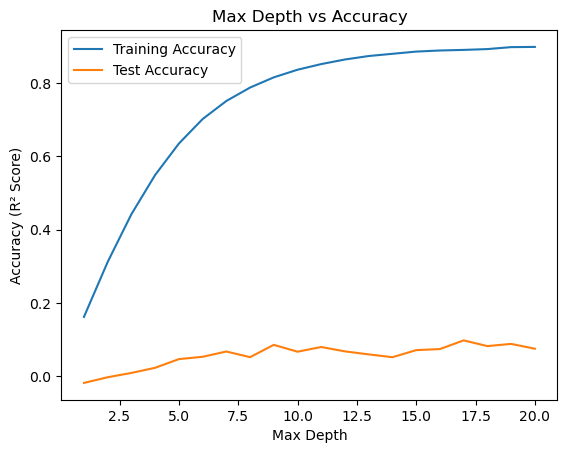

In [86]:
# max depth values
max_depth_values = range(1, 21)
train_accuracies = []
test_accuracies = []

for max_depth in max_depth_values:
    model = RandomForestRegressor(max_depth=max_depth, n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    train_accuracies.append(model.score(X_train, y_train))  # R^2 on training data
    test_accuracies.append(model.score(X_test, y_test))    # R^2 on test data

# Plot the relationship between max_depth and accuracy
plt.plot(max_depth_values, train_accuracies, label="Training Accuracy")
plt.plot(max_depth_values, test_accuracies, label="Test Accuracy")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy (R² Score)")
plt.title("Max Depth vs Accuracy")
plt.legend()
plt.show()